<a href="https://colab.research.google.com/github/P-yushh/Competitions/blob/master/Age_detetection_with_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import time
import re
import warnings
import copy
import cv2
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from torch.autograd import Variable
from torchvision import models, datasets
from torch.utils.data import DataLoader, Dataset
%matplotlib inline
%reload_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

In [0]:
!pip -q install timm
!pip -q install pytorch_ranger
!pip -q install ttach

     |████████████████████████████████| 184kB 6.0MB/s 


In [0]:
import timm
from pytorch_ranger import Ranger
import ttach as tta

In [0]:
def seed_everything(seed):
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed(seed)

seed_everything(0)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

In [0]:
# DOWNLOAD DATASETS
!wget -q https://datahack-prod.s3.amazonaws.com/train_zip/train_DETg9GD.zip
!wget -q https://datahack-prod.s3.amazonaws.com/test_zip/test_Bh8pGW3.zip
!wget -q https://datahack-prod.s3.amazonaws.com/sample_submission/sample_submission_sDO3m7O.csv

!unzip -q train_DETg9GD.zip
!unzip -q test_Bh8pGW3.zip 

!rm test_Bh8pGW3.zip
!rm train_DETg9GD.zip

In [0]:
# LOADING DATASET
traincsv = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission_sDO3m7O.csv')
col_class = sample['Class']
col_class = pd.DataFrame(col_class, columns=['Class'])
test = pd.concat([test, col_class], axis=1)
traincsv.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [0]:
classes = np.unique(traincsv['Class'])
num_classes = len(classes)
print(classes)
print(num_classes)

['MIDDLE' 'OLD' 'YOUNG']
3


In [0]:
def showimg(img, unnormalize=True):
  if unnormalize:
    img = img * 0.5 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))

def plot_loss(train, val):
  x = np.arange(1, len(train)+1)
  plt.figure(figsize=(10,6))
  plt.plot(x, train, label='Training Loss')
  plt.plot(x, val, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Losses!')
  plt.legend(loc='upper right')
  plt.show()

In [0]:
# MAKING DATALOADER
class load_data(Dataset):
  def __init__(self, df, root, phase):
    self.df = df
    self.dir = root
    if phase == 'train':
      self.transforms = A.Compose([A.Resize(320,320), A.RandomCrop(300,300), A.HorizontalFlip(),
                                   A.RGBShift(), A.Rotate(30), A.HueSaturationValue(), A.CLAHE(),
                                   A.GaussNoise(), A.Blur(), A.Cutout(), A.RandomBrightnessContrast(),
                        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), ToTensor()])
    else:
      self.transforms = A.Compose([A.Resize(320,320), A.RandomCrop(300,300), A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), ToTensor()])

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img_id = self.df['ID'].iloc[idx]
    img_path = os.path.join(self.dir, str(img_id))
    labels = self.df.iloc[idx, 1:].to_numpy()
    labels = np.argmax(labels)
    img = plt.imread(img_path)
    img = self.transforms(image=np.array(img))['image']
    return img, labels

In [0]:
def cvrt_to_dumm(data):
  data = pd.get_dummies(data, columns=['Class'], prefix='Class')
  return data

In [0]:
# SPLITTING DATASET INTO TRAINING AND VALIDATION SET
sfk = StratifiedKFold(n_splits=7)
for trn_idx, val_idx in sfk.split(traincsv['Class'], traincsv['Class']):
    train = pd.DataFrame(traincsv.loc[trn_idx].values)
    val = pd.DataFrame(traincsv.loc[val_idx].values)
val.rename(columns={0:'ID',1:'Class'}, inplace=True)
train.rename(columns={0:'ID',1:'Class'}, inplace=True)
train = cvrt_to_dumm(train)
val = cvrt_to_dumm(val)
train.head()

,ID,Class_MIDDLE,Class_OLD,Class_YOUNG
0,377.jpg,1,0,0
1,17814.jpg,0,0,1
2,21283.jpg,1,0,0
3,16496.jpg,0,0,1
4,4487.jpg,1,0,0


In [0]:
#DEFINING DATALOADER
trainset = load_data(train, 'Train', 'train')
valset = load_data(val, 'Train', 'eval')
testset = load_data(test, 'Test', 'eval')
def dataloader(batch_size):
  tdl = DataLoader(trainset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)
  vdl = DataLoader(valset, batch_size=batch_size, pin_memory=False, num_workers=4)
  return {'train':tdl, 'val':vdl}

In [0]:
# SHOWING IMAGES (ONLY 4 FOR BREVITY)
images, label = next(iter(tdl))
showimg(torchvision.utils.make_grid(images))
print(' '.join('{:>10}'.format(classes[label[j]]) for j in range(batch_size)))

NameError: ignored

In [0]:
#DEFINING TRAINER
def train_it(model, dataloader, criterion, optimizer, scheduler, epochs, verbose=False, load_model=False):
  since = time.time()
  train_history = []
  val_history = []
  best_loss = np.inf
  best_val_acc = 0
  if load_model:
    checkpoint = torch.load('model.pth')
    model.load_state_dict(checkpoint['state'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    epoch = checkpoint['epoch']
    best_loss = checkpoint['best_loss']

  train_ldr = dataloader['train']
  val_ldr = dataloader['val']

  model.train()
  for epoch in range(1, epochs+1):
    print('Starting Epoch: {} of {}'.format(epoch, epochs))
    start = time.time()
    tk0 = tqdm(dataloader['train'], desc='Training', total=len(dataloader['train']), position=0)
    total_train_loss = 0.0
    running_acc = 0.0
    for i, (img, labels) in enumerate(tk0):
      img, labels = img.to(device), labels.to(device)

      optimizer.zero_grad()
      score = model(img)
      loss = criterion(score, labels)
      loss.backward()
      optimizer.step()
      _, pred = torch.max(score, dim=1)
      running_acc += torch.sum(pred==labels.data)
      
      total_train_loss += loss.item()*img.size(0)
      tk0.set_postfix(loss = (total_train_loss / ((i+1)*batch_size)))

    epoch_train_acc = running_acc.double() / len(dataloader['train'].dataset)
    timer = time.time() - start
    if verbose:
      print(f'Train Loss: {total_train_loss/len(dataloader["train"].dataset):.4f} \t Train accuracy: {epoch_train_acc.item():.4f}')

    train_history.append(total_train_loss / len(dataloader['train'].dataset))
    
    # EVALUATING NOW...

    model.eval()
    total_val_loss = 0.0
    running_val_acc = 0.0
    with torch.no_grad():
      if verbose:
        print('Starting Validation...')
      tk1 = tqdm(dataloader['val'], desc='Validating', total=len(dataloader['val']))
      for j, (img, labels) in enumerate(tk1):
        img, labels = img.to(device), labels.to(device)
        
        val_score = model(img)
        val_loss = criterion(val_score, labels)
        total_val_loss += val_loss.item() * img.size(0)
        _, vpred = torch.max(val_score, dim=1)
        running_val_acc += torch.sum(vpred==labels.data)
        tk1.set_postfix(loss=(total_val_loss / ((j+1)*batch_size)))

    epoch_val_loss = total_val_loss / len(dataloader['val'].dataset)
    val_history.append(epoch_val_loss)
    val_acc = running_val_acc / len(dataloader['val'].dataset)
    
    
    if scheduler:
      scheduler.step(epoch_val_loss)
    if best_val_acc < val_acc:
      state = {'epoch':epoch, 'best_loss':best_loss,
             'state':model.state_dict(), 'optimizer':optimizer.state_dict(),
             'scheduler':scheduler.state_dict()}
      state['best_loss'] = best_loss = epoch_val_loss
      torch.save(state, 'model.pth')
    if verbose:
      print(f'Validation loss = {epoch_val_loss:.4f} \t Validation accuracy = {val_acc:.4f}')
      print('`````````````````````````````````````````````````````````````````````````````````````````')
  timer = time.time() - since
  if verbose:
    print("Training Finished, took {}m {:.2f}s".format(timer//60, timer%60))

  return train_history, val_history

In [0]:
def test_it(model, testldr):
  model.eval()
  final_pred = []
  with torch.no_grad():
    tk3 = tqdm(testldr, total=len(testldr))
    for (img, label) in tk3:
      img, label = img.to(device), label.to(device)
      output = model(img)
      _, pred = torch.max(output, dim=1)
      final_pred.append(pred.cpu().numpy().data)

    final_pred = np.concatenate(final_pred)
    testcopy['Class'] = final_pred
  return testcopy

In [0]:
# DEFINING ENSEMBLES
class MyEnsemble(nn.Module):
  def __init__(self, model1, model2, model3=None, model4=None, model5=None, n_classes=3):
    super(MyEnsemble, self).__init__()
    self.model1 = model1
    self.model2 = model2
    self.model3 = None
    self.model4 = None
    self.model5 = None
    f1 = model1.classifier.out_features
    f2 = model2.classifier.out_features
    f3 = f4 = f5 = 0
    if model3:
      self.model3 = model3
      f3 = model3.classifier.out_features
    if model4:
      self.model4 = model4
      f4 = model4.classifier.out_features
    if model5:
      self.model5 = model5
      f5 = model5.classifier.out_features
    self.dropout = nn.Dropout(0.2)
    self.classifier = nn.Sequential(nn.Linear(f1+f2+f3+f4+f5, n_classes*2), nn.Dropout(0.2), nn.ReLU(),
                                    nn.Linear(n_classes*2, n_classes))

  def forward(self, x):
    y1 = self.model1(x.clone())
    y1 = y1.view(y1.size(0), -1)
    y2 = self.model2(x.clone())
    y2 = y2.view(y2.size(0), -1)
    temp=0
    if self.model3:
      y3 = self.model3(x.clone())
      y3 = y3.view(y3.size(0), -1)
      temp=1
    if self.model4:
      y4 = self.model4(x.clone())
      y4 = y4.view(y4.size(0), -1)
      temp=2
    if self.model5:
      y5 = self.model5(x.clone())
      y5 = y5.view(y5.size(0), -1)
      temp=3
    
    if temp==0:
      y = torch.cat((y1, y2), dim=1)
    elif temp==1:
      y = torch.cat((y1, y2, y3), dim=1)
    elif temp==2:
      y = torch.cat((y1, y2, y3, y4), dim=1)
    else:
      y = torch.cat((y1, y2, y3, y4, y5), dim=1)
    y = self.dropout(y)
    out = self.classifier(F.relu(y))
    return out

In [0]:
# DOWNLOADING MODEL
model1 = timm.create_model('efficientnet_b3', pretrained=True, num_classes=128, drop_rate=0.2)
model2 = timm.create_model('efficientnet_b2', pretrained=True, num_classes=128, drop_rate=0.25)
#model3 = timm.create_model('efficientnet_b1', pretrained=True, num_classes=128, drop_rate=0.25)
#model_classes = model.classifier.in_features

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra-a5e2fbc7.pth" to /root/.cache/torch/checkpoints/efficientnet_b3_ra-a5e2fbc7.pth
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b2_ra-bcdf34b7.pth" to /root/.cache/torch/checkpoints/efficientnet_b2_ra-bcdf34b7.pth


In [0]:
# DEFINING MODEL PARAMS
#model.classifier = nn.Sequential(nn.Linear(model_classes, num_classes*2), nn.Dropout(0.2), nn.ReLU(), nn.Linear(num_classes*2, num_classes))
#model1 = model1.to(device)
#model2 = model2.to(device)
#model3 = model3.to(device)
model = MyEnsemble(model1, model2)
model = model.to(device)
#optimizer = optim.Adam(model.fc.parameters(), lr=2e-4, betas=(0.9, 0.999),weight_decay=0.004)
optimizer = Ranger(model.parameters(), lr=1e-4, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, mode='min', threshold=0.01, patience=2, verbose=True)


In [0]:
batch_size = 26
dataldr = dataloader(batch_size)

In [28]:
train_hist, val_hist = train_it(model,  dataldr, criterion, optimizer, scheduler, 5, verbose=True, load_model=True)

Starting Epoch: 1 of 5



Train Loss: 0.4514 	 Train accuracy: 0.8159
Starting Validation...



Validation loss = 0.3849 	 Validation accuracy = 0.8646
`````````````````````````````````````````````````````````````````````````````````````````
Starting Epoch: 2 of 5



Train Loss: 0.1511 	 Train accuracy: 0.9437
Starting Validation...



Epoch    18: reducing learning rate of group 0 to 2.7000e-06.
Validation loss = 0.3752 	 Validation accuracy = 0.8903
`````````````````````````````````````````````````````````````````````````````````````````
Starting Epoch: 3 of 5



Train Loss: 0.0978 	 Train accuracy: 0.9647
Starting Validation...



Validation loss = 0.3794 	 Validation accuracy = 0.8892
`````````````````````````````````````````````````````````````````````````````````````````
Starting Epoch: 4 of 5



Train Loss: 0.0922 	 Train accuracy: 0.9659
Starting Validation...



Validation loss = 0.3892 	 Validation accuracy = 0.8934
`````````````````````````````````````````````````````````````````````````````````````````
Starting Epoch: 5 of 5



Train Loss: 0.0774 	 Train accuracy: 0.9714
Starting Validation...



Epoch    21: reducing learning rate of group 0 to 8.1000e-07.
Validation loss = 0.4145 	 Validation accuracy = 0.8899
`````````````````````````````````````````````````````````````````````````````````````````
Training Finished, took 45.0m 19.05s


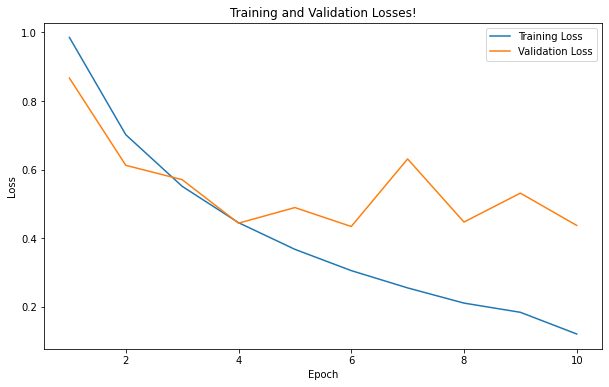

In [0]:
 # PLOTTING LOSSES
plot_loss(train_hist, val_hist)

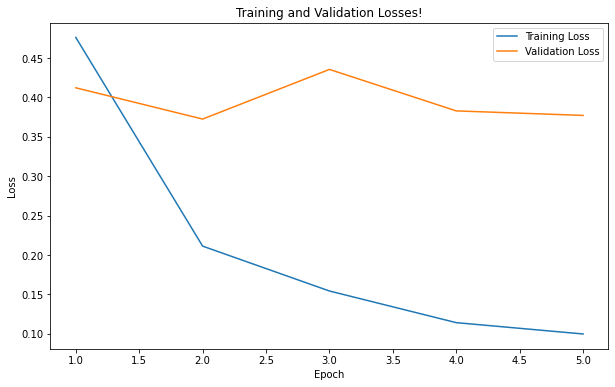

In [0]:
# PLOTTING LOSSES
plot_loss(train_hist, val_hist)

In [0]:
# APPLYING TEST TIME TRANSFORMS
test_tf = tta.Compose([tta.HorizontalFlip(), tta.Multiply(factors=[0.9, 1, 1.1])])
tta_model = tta.ClassificationTTAWrapper(model, test_tf, merge_mode = 'mean')

In [0]:
checkpoint = torch.load('model.pth')
checkpoint['epoch']

6

In [0]:
testdl = DataLoader(testset, batch_size=12, pin_memory=True, num_workers=4)

In [0]:
testcopy = test.copy()
prediction = test_it(tta_model, testdl)
prediction.head()

,ID,Class
0,25321.jpg,0
1,989.jpg,2
2,19277.jpg,0
3,13093.jpg,0
4,5367.jpg,0


In [0]:
mapper = {'Class':{0:'MIDDLE', 1:'OLD', 2:'YOUNG'}}
prediction.replace(mapper, inplace=True)
new_col = ['Class', 'ID']
prediction = prediction.reindex(columns=new_col)
prediction.head()

,Class,ID
0,MIDDLE,25321.jpg
1,YOUNG,989.jpg
2,MIDDLE,19277.jpg
3,MIDDLE,13093.jpg
4,MIDDLE,5367.jpg


In [0]:
prediction.to_csv('ttasubmission.csv', index=False)

In [0]:
torch.cuda.empty_cache()